In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoDiagonalNormal

from stream_membership import ComponentMixtureModel, ModelComponent
from stream_membership.distributions import IndependentGMM, TruncatedNormalSpline, DirichletSpline, TruncatedNormal1DSplineMixture
from stream_membership.plot import plot_data_projections

import astropy.table as at
import astropy.units as u

import pickle
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
import importlib
import sys
sys.path.append('../../')
sys.path.append('/Users/Tavangar/Work/CATS_workshop/cats/')

import scripts.initialize_stream as init_stream
from scripts.run_full_gd1_model import *

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

In [3]:
data = at.Table.read("/Users/Tavangar/Work/CATS_Workshop/cats/data/joined-GD-1.fits")

pawprint,iso_obj,iso_mask,hb_mask,pmsel,pm_mask = run_CATS(data, stream_name='GD-1', phi1_lim=[-100,20])

Modifying/extrapolating galstreams track
Modifying/extrapolating galstreams track
-40.18182129005669
Fitting for peak pm location
Pre-fitting mean PM values: -13.031, -3.108
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [np.float64(-13.271475187973863), np.float64(-3.1697646472516334), np.float64(0.5058218775428639), np.float64(0.3829921285438014)] 

Producing the polygon and mask


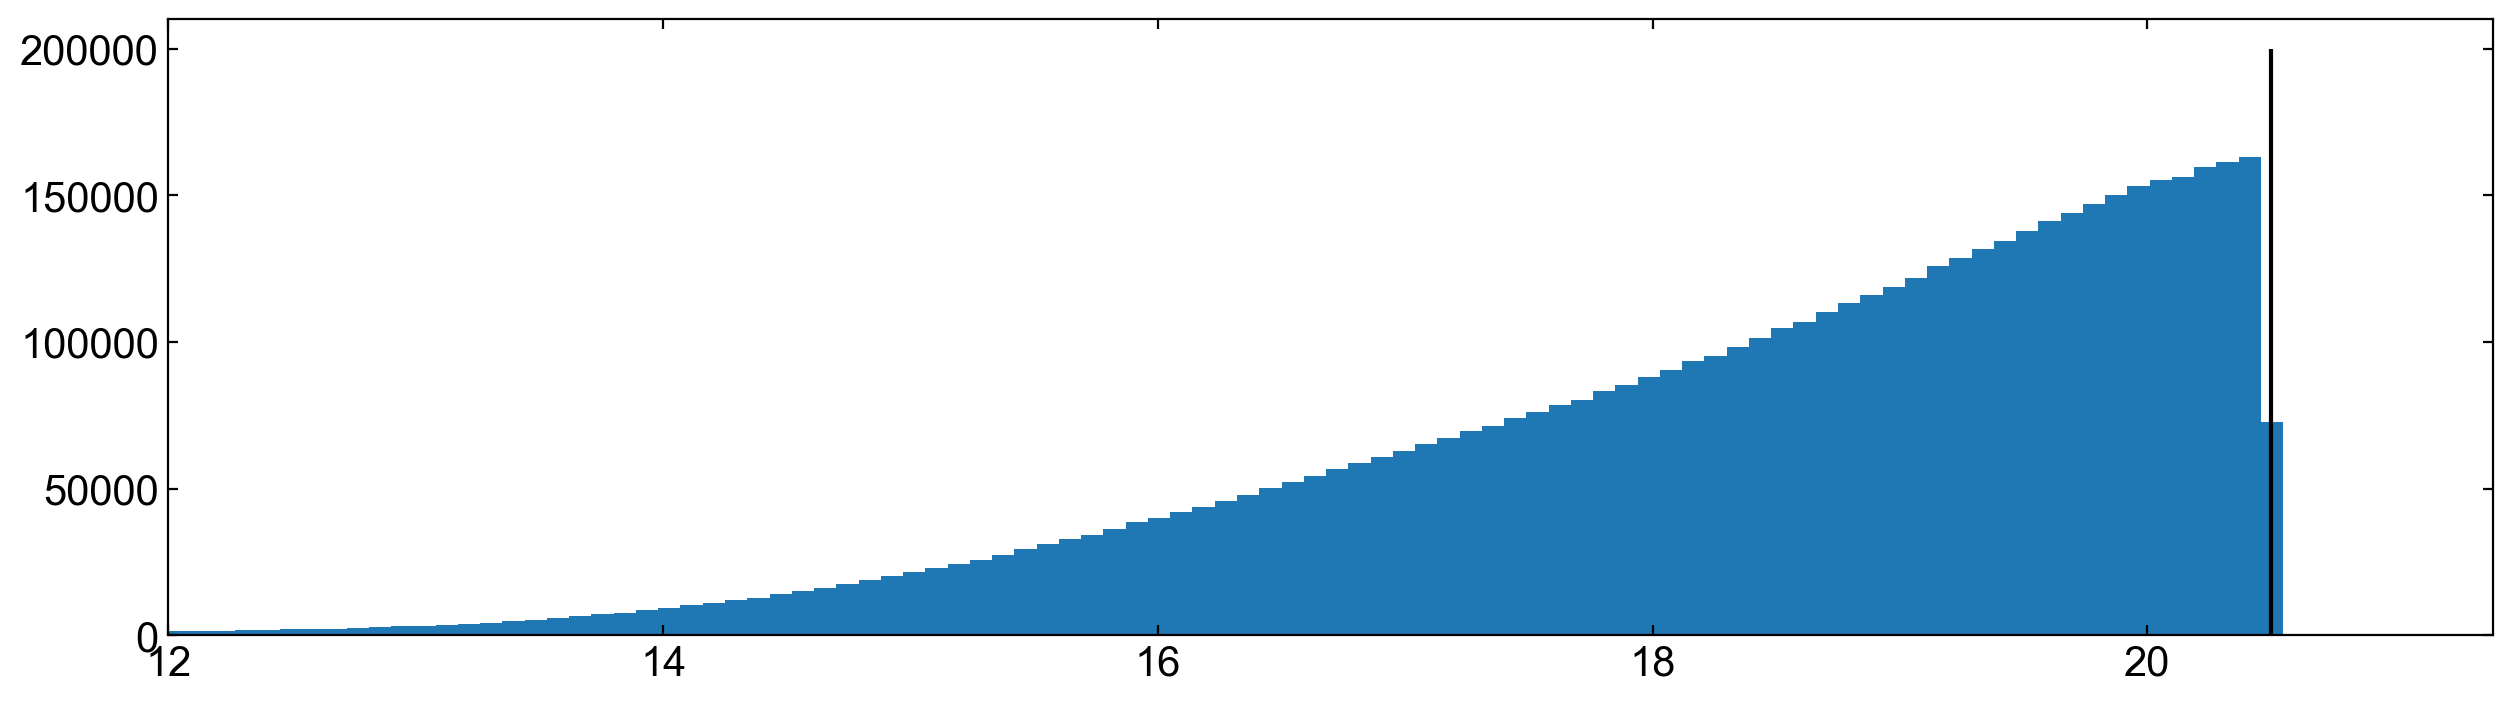

In [4]:
plt.figure(figsize=(15,4))
plt.hist(iso_obj.cat['phot_g_mean_mag'], bins=100, range=[12,21])
plt.vlines(20.5, 0, 200000, color='k')
plt.xlim(12, 21.4)
plt.show()

In [6]:
run_data_ = iso_obj.cat[pm_mask & (iso_mask | hb_mask)]
run_data = {k: jnp.array(run_data_[k], dtype="f8") for k in run_data_.colnames}

bkg_data_ = iso_obj.cat[pm_mask & (iso_mask | hb_mask) & ~iso_obj.on_skymask]
bkg_data = {k: jnp.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}


stream_data_ = iso_obj.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & iso_obj.on_skymask]
stream_data = {k: jnp.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

In [9]:
coord_bounds, plot_grids = init_stream.get_bounds_and_grids(run_data, pawprint)

In [58]:
bkg_knot_spacings    = jnp.array([40,40,40])
stream_knot_spacings = jnp.array([5,20,20,20])
offtrack_dx          = jnp.array([3,1])

bkg_model = init_stream.make_bkg_model_component(knot_spacings=bkg_knot_spacings, n_pm_mixture=2, 
                                                 coord_bounds=coord_bounds, data=bkg_data)
stream_model = init_stream.make_stream_model_component(knot_spacings=stream_knot_spacings, 
                                                       coord_bounds=coord_bounds, data=stream_data)
offtrack_model, offtrack_phi12_locs = init_stream.make_offtrack_model_component(offtrack_dx, stream_model, 
                                                                                coord_bounds)

mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0, 2.0])),
    components=[bkg_model, stream_model, offtrack_model],
    tied_coordinates={"offtrack": {"pm1": "stream", "pm2": "stream"}},
)

In [185]:
specifications = jnp.concatenate([bkg_knot_spacings, stream_knot_spacings, offtrack_dx])

svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
filename = svi_results_dir + 'full_mm_bkg{}_{}_{}_stream{}_{}_{}_{}_off{}_{}.pkl'.format(*specifications)

with open(filename, 'rb') as input_file_:
    full_dict = pickle.load(input_file_)
    
MAP_svi_results = full_dict['svi_results']
guide = full_dict['guide']

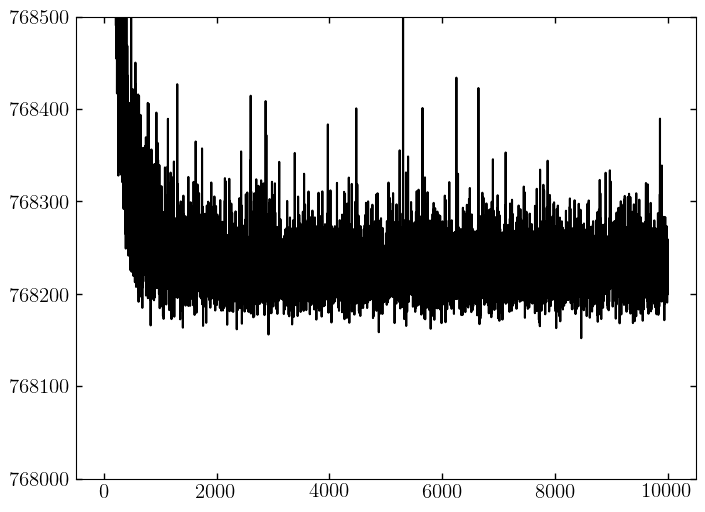

In [186]:
plt.plot(MAP_svi_results.losses)
plt.ylim(768000, 768500)
plt.show()

pred_dist = Predictive(guide, params=MAP_svi_results.params, num_samples=10_000)
MAP_p_ = pred_dist(jax.random.PRNGKey(42), data=run_data)
MAP_p = {k: jnp.median(v, axis=0) for k, v in MAP_p_.items()}
MAP_p_expanded = mm.expand_numpyro_params(MAP_p)

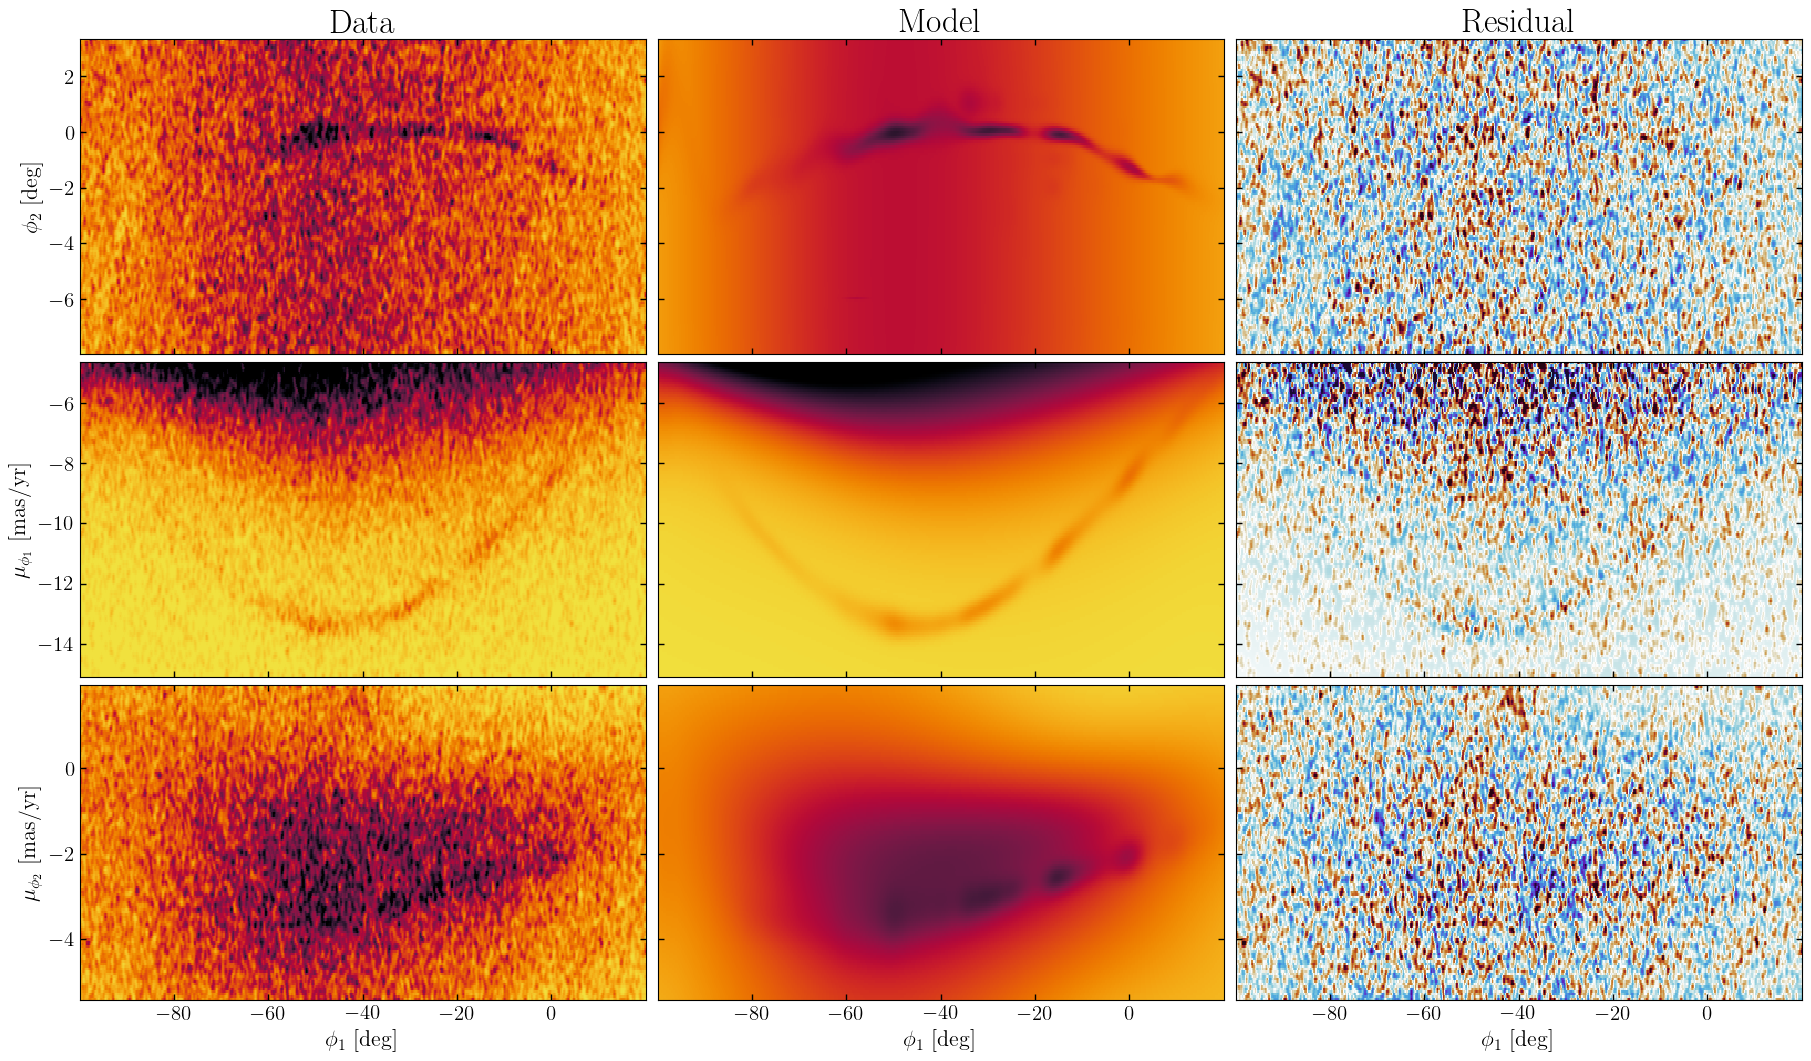

In [187]:
fig, axes = plt.subplots(
    len(mm.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(mm.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

#axes = jnp.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=[axes[0, 0], axes[2,0]],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)

mm.plot_model_projections(data=run_data, grids=plot_grids, pars=MAP_p_expanded, axes=axes[:, 1], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
mm.plot_model_projections(data=run_data, grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                          pars=MAP_p_expanded, axes=[axes[0, 1], axes[2,1]], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))

mm.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_expanded,
    data=run_data, axes=axes[:, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)

plt.savefig('../../paper_figures/full_model.pdf')
plt.show()

In [267]:
mm['stream', 'offtrack']

KeyError: ('stream', 'offtrack')

Text(0.5, 0, '')

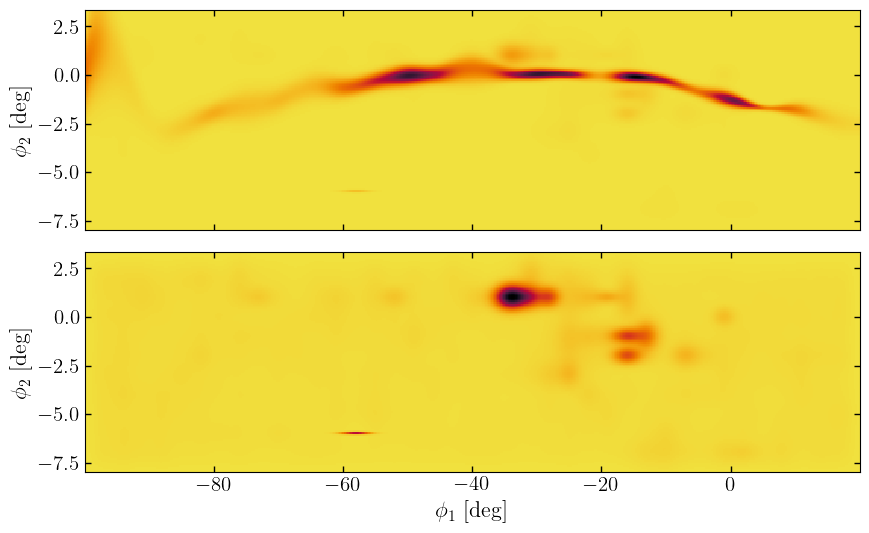

In [269]:
str_off_mm = ComponentMixtureModel(
dist.Dirichlet(jnp.array([1.0, 1.0])),
components=[stream_model, offtrack_model],
tied_coordinates={"offtrack": {"pm1": "stream", "pm2": "stream"}},
)

str_off_mm_params = {
    "stream": MAP_p_expanded["stream"],
    "offtrack": MAP_p_expanded["offtrack"],
}
str_off_mm_packed_params = str_off_mm.pack_params(str_off_mm_params)
str_off_mm_packed_params["mixture-probs"] = MAP_p_expanded["mixture-probs"][1:] / jnp.sum(MAP_p_expanded["mixture-probs"][1:])
str_off_mm_packed_params["mixture"] = jnp.stack([v for v in run_data.values()], axis=-1)

fig, [ax1, ax2] = plt.subplots(2,1,figsize=(10,6), sharex=True)
_ = str_off_mm.plot_model_projections(data=stream_data, pars=str_off_mm_packed_params, grids=plot_grids, grid_coord_names=[('phi1', 'phi2')], axes=ax1, label=True,
                                      pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap))

_ = mm['offtrack'].plot_model_projections(data=stream_data, grids=plot_grids, pars=MAP_p_expanded['offtrack'], grid_coord_names=[('phi1', 'phi2')], axes=ax2,
                                          pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap))
ax1.set_xlabel("")

### Make Linear Density Plot

In [189]:
stream_opt = mm['stream']
offtrack_opt = mm['offtrack']

stream_params = MAP_p_expanded['stream']
offtrack_params = MAP_p_expanded['offtrack']

grids_stream, ln_ns_stream = stream_opt.evaluate_on_2d_grids(pars=stream_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])
grids_off, ln_ns_off = offtrack_opt.evaluate_on_2d_grids(pars=offtrack_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])

In [190]:
phi1s = grids_stream[('phi1','phi2')][0][0][1:] - 0.1
stream_lin_dens = jnp.exp(ln_ns_stream[('phi1', 'phi2')]).sum(axis=0) / (phi1s[1]-phi1s[0])
off_lin_dens = jnp.exp(ln_ns_off[('phi1', 'phi2')]).sum(axis=0) / (phi1s[1]-phi1s[0])


phi2_track = IUS(stream_opt.coord_parameters['phi2']['knots'], stream_params['phi2']['loc_vals'])
phi2_width = IUS(stream_opt.coord_parameters['phi2']['knots'], stream_params['phi2']['scale_vals'])
pm1_track = IUS(stream_opt.coord_parameters['pm1']['knots'], stream_params['pm1']['loc_vals'])
pm1_width = IUS(stream_opt.coord_parameters['pm1']['knots'], stream_params['pm1']['scale_vals'])
pm2_track = IUS(stream_opt.coord_parameters['pm2']['knots'], stream_params['pm2']['loc_vals'])
pm2_width = IUS(stream_opt.coord_parameters['pm2']['knots'], stream_params['pm2']['scale_vals'])


# phi2_track_no_off = IUS(stream_phi2_knots, MAP_p_no_off_expanded['stream']['phi2']['loc_vals'])
# phi2_width_no_off = IUS(stream_phi2_knots, MAP_p_no_off_expanded['stream']['phi2']['scale_vals'])
# pm1_track_no_off = IUS(stream_pm1_knots, MAP_p_no_off_expanded['stream']['pm1']['loc_vals'])
# pm1_width_no_off = IUS(stream_pm1_knots, MAP_p_no_off_expanded['stream']['pm1']['scale_vals'])
# pm2_track_no_off = IUS(stream_pm2_knots, MAP_p_no_off_expanded['stream']['pm2']['loc_vals'])
# pm2_width_no_off = IUS(stream_pm2_knots, MAP_p_no_off_expanded['stream']['pm2']['scale_vals'])

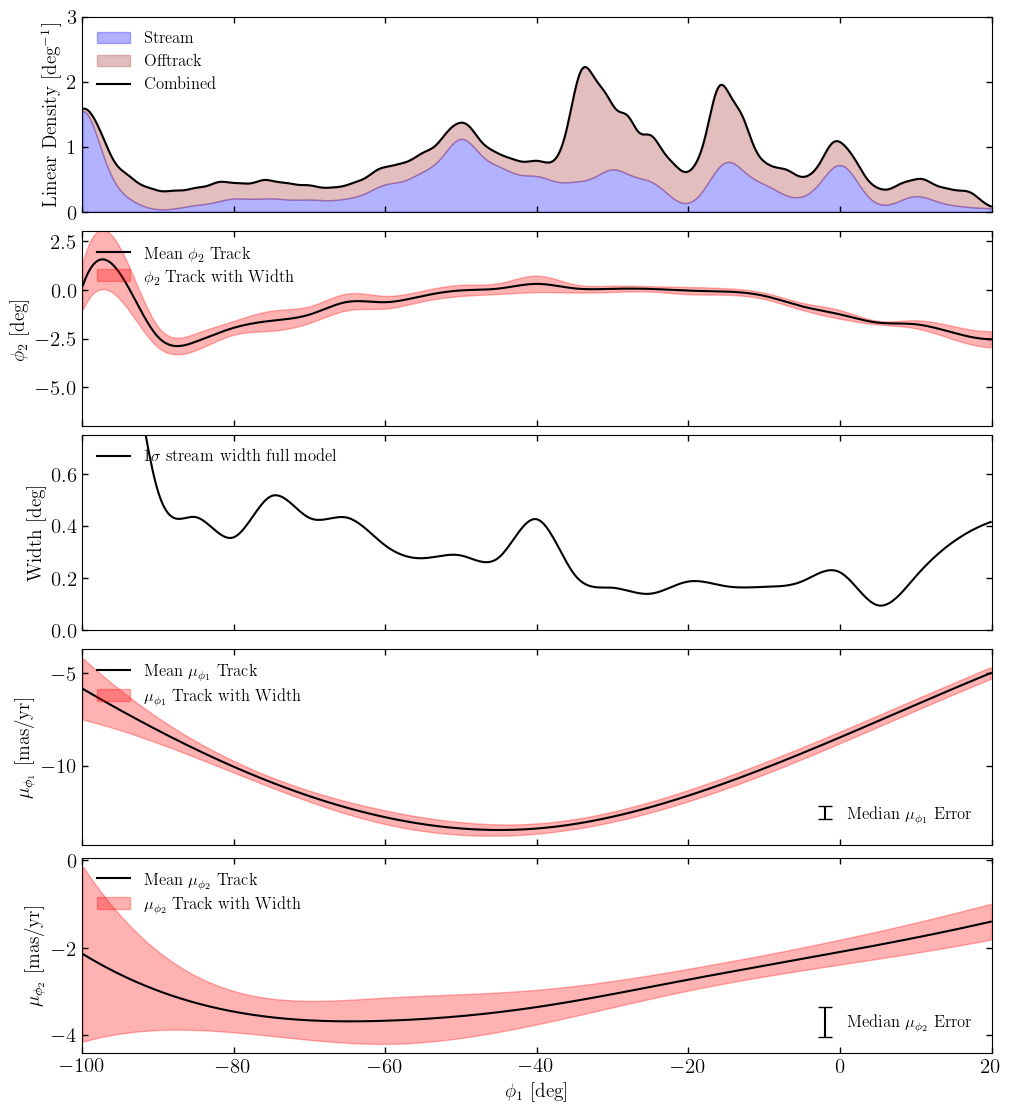

In [191]:
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5, 1, figsize=(10,11), constrained_layout=True, sharex=True)
ax1.fill_between(phi1s, stream_lin_dens-stream_lin_dens, stream_lin_dens, color='b', alpha=0.3, label=r'Stream')
ax1.fill_between(phi1s, stream_lin_dens, stream_lin_dens+off_lin_dens, color='brown', alpha=0.3, label=r'Offtrack')
ax1.plot(phi1s, stream_lin_dens+off_lin_dens, color='k', label=r'Combined')
ax1.set_ylabel(r'Linear Density [deg$^{-1}$]', fontsize=14)
ax1.set_ylim(0,3)
ax1.legend(fontsize=12, loc='upper left')

ax2.plot(phi1s, phi2_track(phi1s), c='k', label=r'Mean $\phi_2$ Track')
ax2.fill_between(phi1s, phi2_track(phi1s) - phi2_width(phi1s), phi2_track(phi1s) + phi2_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\phi_2$ Track with Width')
# ax2.fill_between(phi1s, phi2_track_no_off(phi1s) - phi2_width_no_off(phi1s), 
#                  phi2_track_no_off(phi1s) + phi2_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\phi_2$ Track with Width')
ax2.set_ylim(-7, 3)
ax2.set_ylabel(r'$\phi_2$ [deg]', fontsize=14)
ax2.legend(fontsize=12, loc='upper left')

ax3.plot(phi1s, phi2_width(phi1s), c='k', label=r'$1\sigma$ stream width full model')
# ax3.plot(phi1s, phi2_width_no_off(phi1s), c='k', ls='dashed', label=r'$1\sigma$ stream width no offtrack')
ax3.set_ylim(0, 0.75)
ax3.set_ylabel(r'Width [deg]', fontsize=14)
ax3.legend(fontsize=12, loc='upper left')

ax4.plot(phi1s, pm1_track(phi1s), c='k', label=r'Mean $\mu_{\phi_1}$ Track')
ax4.errorbar(-2, -12.5, yerr=0.35, fmt='', capsize=5, color='black')
ax4.text(1, -12.8, r'Median $\mu_{\phi_1}$ Error', fontsize=12)
ax4.fill_between(phi1s, pm1_track(phi1s) - pm1_width(phi1s), pm1_track(phi1s) + pm1_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\mu_{\phi_1}$ Track with Width')
# ax4.fill_between(phi1s, pm1_track_no_off(phi1s) - pm1_width_no_off(phi1s), 
#                  pm1_track_no_off(phi1s) + pm1_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\mu_{\phi_1}$ Track with Width')
ax4.set_ylabel(r'$\mu_{\phi_1}$ [mas/yr]', fontsize=14)
ax4.legend(fontsize=12, loc='upper left')

ax5.plot(phi1s, pm2_track(phi1s), c='k', label=r'Mean $\mu_{\phi_2}$ Track')
ax5.errorbar(-2, -3.7, yerr=0.35, fmt='', capsize=5, color='black')
ax5.text(1, -3.8, r'Median $\mu_{\phi_2}$ Error', fontsize=12)
ax5.fill_between(phi1s, pm2_track(phi1s) - pm2_width(phi1s), pm2_track(phi1s) + pm2_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\mu_{\phi_2}$ Track with Width')
# ax5.fill_between(phi1s, pm2_track_no_off(phi1s) - pm2_width_no_off(phi1s), 
#                  pm2_track_no_off(phi1s) + pm2_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\mu_{\phi_2}$ Track with Width')
ax5.set_ylabel(r'$\mu_{\phi_2}$ [mas/yr]', fontsize=14)
ax5.legend(fontsize=12, loc='upper left')

ax5.set_xlim(-100, 20)
ax5.set_xlabel(r'$\phi_1$ [deg]', fontsize=14)

# plt.savefig('../paper_figures/stream_properties.pdf')
plt.show()

In [192]:
all_data_ = iso_obj.cat[pm_mask]
all_data = {k: jnp.array(all_data_[k], dtype="f8") for k in all_data_.colnames}

In [193]:
lp_dict = {}
for n_comp, component in enumerate(mm.components):
    
    print(component.name)
    dists = component.make_dists(MAP_p_expanded[component.name])

    component_lp_stack = jnp.empty((len(dists), len(all_data_)))

    for i, (coord_name, dist_) in enumerate(dists.items()):
        if isinstance(coord_name, tuple):
            _data = jnp.stack([all_data[k] for k in coord_name], axis=-1)
        else:
            _data = jnp.asarray(all_data[coord_name])

        if isinstance(dist_, (IndependentGMM, dist.Uniform)):
            variable_lp  = dist_.log_prob(value=_data)
        else:
            variable_lp = dist_.log_prob(value=_data, x=jnp.asarray(all_data['phi1']))
        component_lp_stack = component_lp_stack.at[i].set(variable_lp)
    # comp_lp = jax.scipy.special.logsumexp(component_lp_stack, axis=0) +lp
    comp_lp = jnp.sum(component_lp_stack, axis=0) + jnp.log(MAP_p_expanded['mixture-probs'][n_comp])
    lp_dict[component.name] = comp_lp
    print(comp_lp, jnp.max(comp_lp)) 

background
[-10.74293066 -10.04376791 -12.17407199 ... -11.53186651 -13.00790424
 -11.30614631] -9.519156180627938
stream
[-296.19229882 -270.51764246 -127.08031236 ... -247.11991124 -171.15804017
 -198.18751175] -6.385970558704623
offtrack
[-201.01632436 -175.5767141   -32.9060666  ... -117.490129    -43.33118772
  -66.17548823] -8.377247772461292


In [194]:
sum_probs = jnp.exp(lp_dict['background']) + jnp.exp(lp_dict['stream']) + jnp.exp(lp_dict['offtrack'])
memb_prob = (jnp.exp(lp_dict['stream']) + jnp.exp(lp_dict['offtrack'])) / sum_probs
print((memb_prob > 0.5).sum())
print((memb_prob > 0.7).sum())
print((memb_prob > 0.9).sum())
print((memb_prob > 0.99).sum())

3442
2295
1637
573


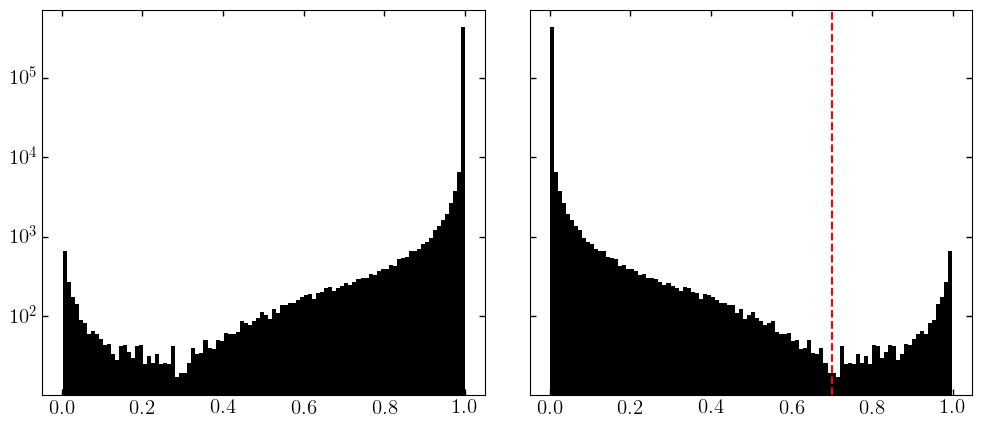

In [195]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,5), sharey=True)
ax1.hist(jnp.exp(lp_dict['background']) / sum_probs, bins=100)
ax1.set_yscale('log')

ax2.hist(memb_prob, bins=100)
ax2.set_yscale('log')
ax2.axvline(0.7, c='r', ls='--')

plt.show()

In [196]:
memb_sel1 = np.array(memb_prob>0.5)
memb_sel2 = np.array(memb_prob>0.7)
memb_sel3 = np.array(memb_prob>0.9)
bad_cmd_sel = (all_data_['g0'] - all_data_['r0']) > 0.6

In [197]:
print(len(all_data_[memb_sel2]))
print(len(all_data_[memb_sel2&~bad_cmd_sel]))

2295
1924


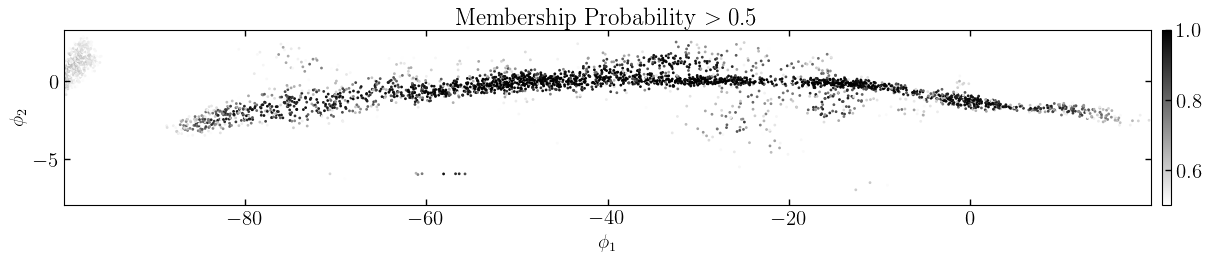

In [198]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,2.5), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], c=memb_prob[memb_sel1], s=1, vmin=0.5, vmax=1, cmap='gray_r')
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_title(r'Membership Probability $> 0.5$')
ax1.set_xlim(coord_bounds['phi1'])
ax1.set_ylim(coord_bounds['phi2'])
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
cbar = fig.colorbar(im1, ax=ax1, pad=0.01)
plt.show()

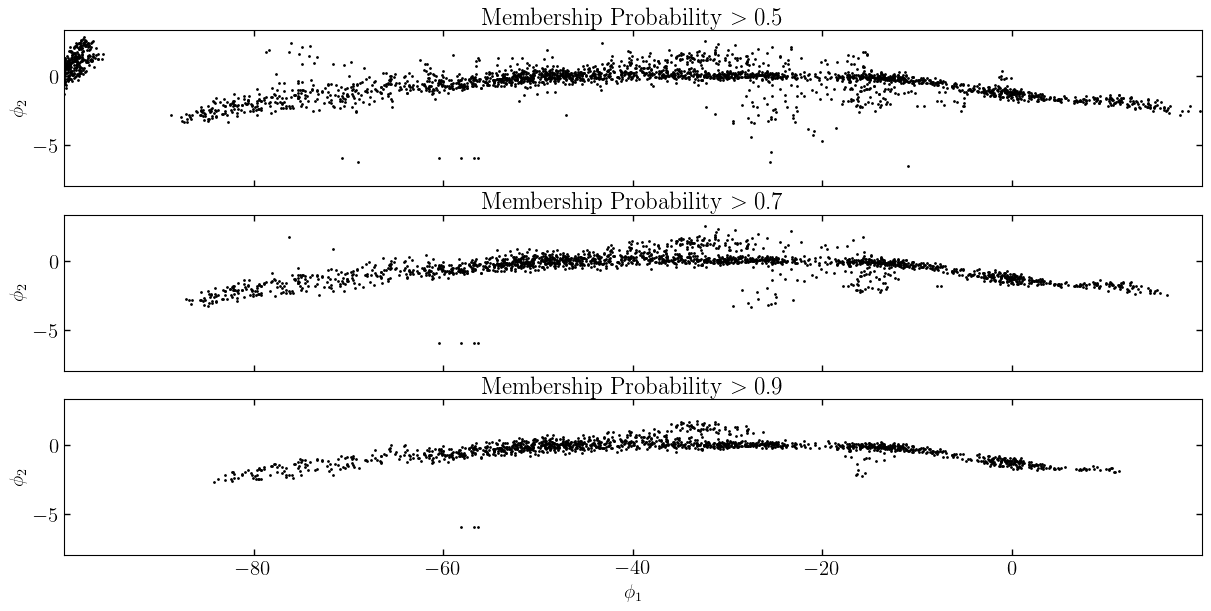

In [199]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(12,6), sharex=True, sharey=True, constrained_layout=True)
ax1.scatter(all_data_[memb_sel1&~bad_cmd_sel]['phi1'], all_data_[memb_sel1&~bad_cmd_sel]['phi2'], s=1)
ax1.set_title(r'Membership Probability $> 0.5$')
ax1.set_xlim(coord_bounds['phi1'])
ax1.set_ylim(coord_bounds['phi2'])

ax2.scatter(all_data_[memb_sel2&~bad_cmd_sel]['phi1'], all_data_[memb_sel2&~bad_cmd_sel]['phi2'], s=1)
ax2.set_title(r'Membership Probability $> 0.7$')

ax3.scatter(all_data_[memb_sel3&~bad_cmd_sel]['phi1'], all_data_[memb_sel3&~bad_cmd_sel]['phi2'], s=1)
ax3.set_title(r'Membership Probability $> 0.9$')

ax1.set_ylabel(r'$\phi_2$')
ax2.set_ylabel(r'$\phi_2$')
ax3.set_ylabel(r'$\phi_2$')
ax3.set_xlabel(r'$\phi_1$')
plt.show()

### Create the distance-corrected CMD

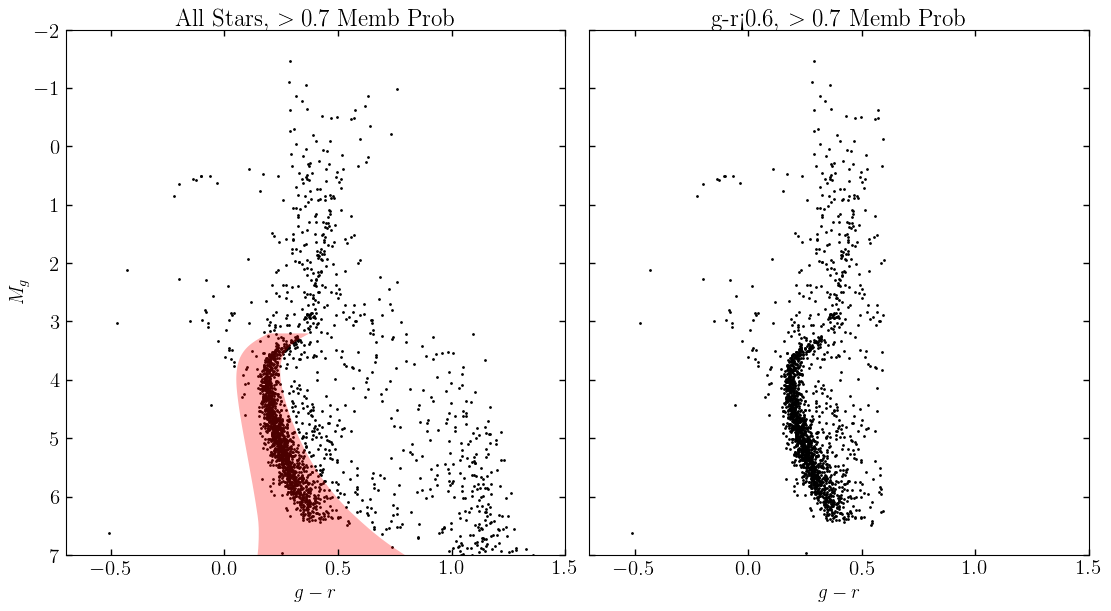

In [87]:
distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])
dist_mod_correct_all = distmod_spl(all_data_[memb_sel2]["phi1"]) - iso_obj.dist_mod
dist_mod_correct_cmd_cut = distmod_spl(all_data_[memb_sel2&~bad_cmd_sel]["phi1"]) - iso_obj.dist_mod

cmd_poly = iso_obj.pawprint.cmdprint.vertices - jnp.array([0,iso_obj.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.3)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(11,6), sharex=True, sharey=True, constrained_layout=True)
ax1.scatter(all_data_[memb_sel2]['g0'] - all_data_[memb_sel2]['r0'], 
            all_data_[memb_sel2]['g0'] - dist_mod_correct_all  - iso_obj.dist_mod, 
            c='k', s=1)
ax1.add_patch(cmd_patch)
ax1.set_title(r'All Stars, $>0.7$ Memb Prob')

ax1.set_xlabel(r'$g-r$', fontsize=14)
ax1.set_ylabel(r'$M_g$', fontsize=14)

ax1.set_xlim(-0.7, 1.5)
ax1.set_ylim(7, -2)

ax2.scatter(all_data_[memb_sel2&~bad_cmd_sel]['g0'] - all_data_[memb_sel2&~bad_cmd_sel]['r0'], 
            all_data_[memb_sel2&~bad_cmd_sel]['g0'] - dist_mod_correct_cmd_cut  - iso_obj.dist_mod, 
            c='k', s=1)
ax2.set_title(r'g-r<0.6, $>0.7$ Memb Prob')

ax2.set_xlabel(r'$g-r$', fontsize=14)

ax2.set_xlim(-0.7, 1.5)
ax2.set_ylim(7, -2)
plt.show()

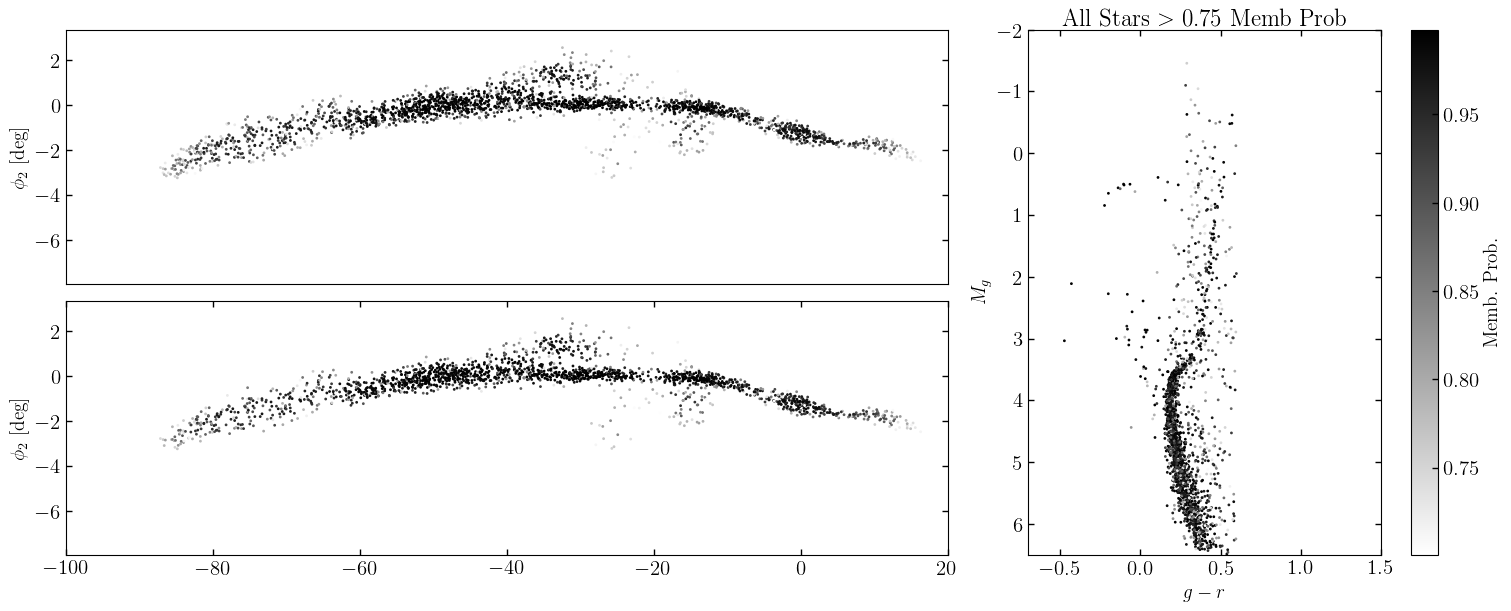

In [81]:
c_map='gray_r'

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15,6), layout="constrained")
gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 0.4])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:,1])

im1 = ax1.scatter(all_data_[memb_sel2]['phi1'], all_data_[memb_sel2]['phi2'], c=memb_prob[memb_sel2],
            s=1, cmap=c_map)
# ax1.set_xlabel(r"$\phi_1$ [deg]", fontsize=14)
ax1.set_ylabel(r"$\phi_2$ [deg]", fontsize=14)
ax1.set_xlim(-100, 20)
ax1.set_ylim(coord_bounds['phi2'])

ax1.xaxis.set_visible(False)

im2 = ax2.scatter(all_data_[memb_sel2&~bad_cmd_sel]['phi1'], all_data_[memb_sel2&~bad_cmd_sel]['phi2'], 
                  c=memb_prob[memb_sel2&~bad_cmd_sel],
            s=1, cmap=c_map)
# ax1.set_xlabel(r"$\phi_1$ [deg]", fontsize=14)
ax2.set_ylabel(r"$\phi_2$ [deg]", fontsize=14)
ax2.set_xlim(-100, 20)
ax2.set_ylim(coord_bounds['phi2'])

im3 = ax3.scatter(all_data_[memb_sel2&~bad_cmd_sel]['g0'] - all_data_[memb_sel2&~bad_cmd_sel]['r0'], 
                  all_data_[memb_sel2&~bad_cmd_sel]['g0'] - dist_mod_correct_all  - iso_obj.dist_mod, 
                  c=memb_prob[memb_sel2&~bad_cmd_sel], s=1, cmap=c_map)
# ax3.add_patch(cmd_patch)
ax3.set_title(r'All Stars $>0.75$ Memb Prob')

ax3.set_xlabel(r'$g-r$', fontsize=14)
ax3.set_ylabel(r'$M_g$', fontsize=14)

ax3.set_xlim(-0.7, 1.5)
ax3.set_ylim(6.5, -2)

cbar = fig.colorbar(im3, ax=ax3)
cbar.set_label('Memb. Prob.', fontsize=14)
# plt.savefig('../../paper_figures/high_prob_members.pdf')
plt.show()

In [72]:
run_data_.write('gd1_memb_prob_post_CMD_cut.fits', overwrite=True)
most_cat_.write('gd1_memb_prob_all.fits', overwrite=True)

## Make Paper Plots

### Background Model

In [89]:
svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
bkg_filename = svi_results_dir + 'bkg_{}_{}_{}.pkl'.format(*bkg_knot_spacings)

with open(bkg_filename, 'rb') as input_file_:
    bkg_dict = pickle.load(input_file_)
    
bkg_svi_results = bkg_dict['svi_results']
bkg_guide = bkg_dict['guide']

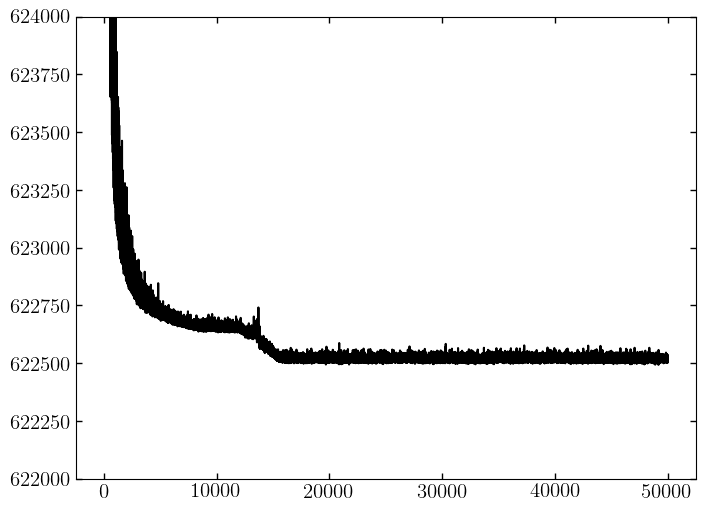

In [95]:
plt.plot(bkg_svi_results.losses)
plt.ylim(6.22e5, 6.24e5)

bkg_params = get_svi_params(model=bkg_model, data=bkg_data, svi_results=bkg_svi_results, 
                            guide=bkg_guide, num_samples=10_000, key=jax.random.PRNGKey(12345))

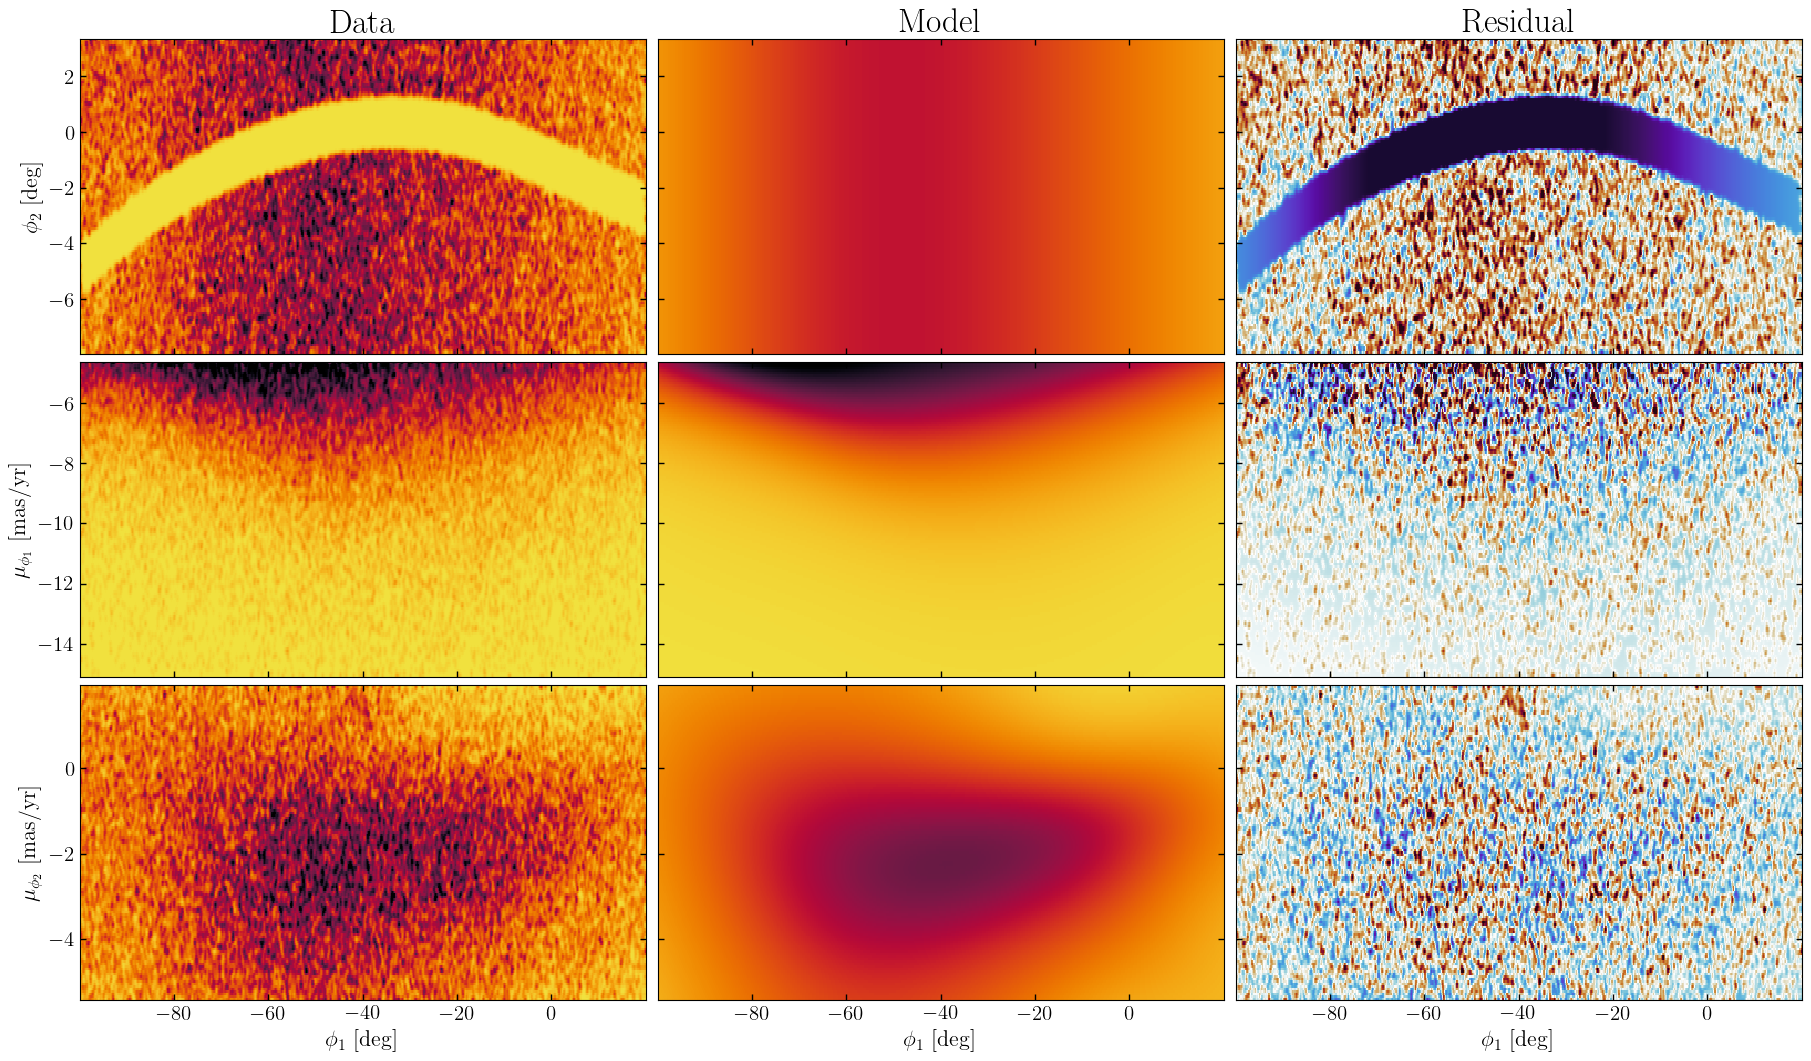

In [133]:
import cmasher as cmr
cmap=cmr.ember_r

fig, axes = plt.subplots(
    len(bkg_model.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(bkg_model.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

plot_data_projections(
    data=bkg_data,
    grids=plot_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=bkg_data,
    grids=plot_grids,
    axes=[axes[0, 0], axes[2,0]],
    pcolormesh_kwargs=dict(rasterized=True, vmax=2.5, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)

bkg_model.plot_model_projections(data=bkg_data, grids=plot_grids, pars=bkg_params, axes=axes[:, 1], label=False,
                                 pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
bkg_model.plot_model_projections(data=bkg_data, grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                                 pars=bkg_params, axes=[axes[0, 1], axes[2,1]], label=False,
                                 pcolormesh_kwargs=dict(rasterized=True, vmax=2.5, vmin=0, cmap=cmap))

bkg_model.plot_residual_projections(
    grids=plot_grids, pars=bkg_params,
    data=bkg_data, axes=axes[:, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap=cmr.fusion, rasterized=True)
)

axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.savefig('../../paper_figures/bkg_model.pdf')
plt.show()

### Stream Model

In [117]:
svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
stream_filename = svi_results_dir + 'stream_{}_{}_{}_{}.pkl'.format(*stream_knot_spacings)

with open(stream_filename, 'rb') as input_file_:
    stream_dict = pickle.load(input_file_)
    
stream_svi_results = stream_dict['svi_results']
stream_guide = stream_dict['guide']

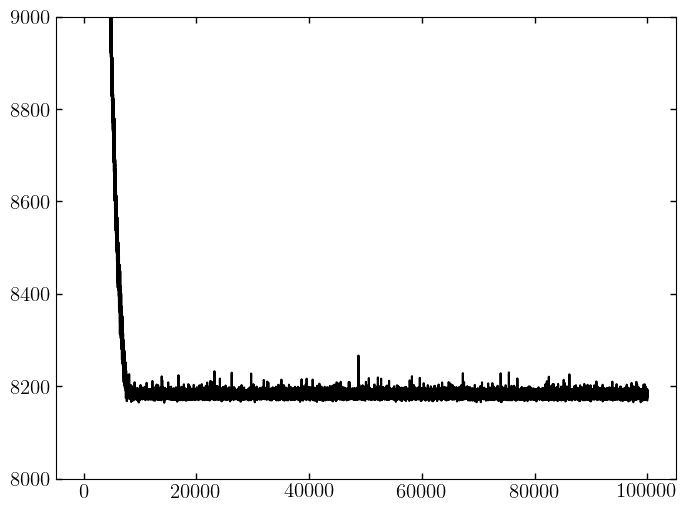

In [120]:
plt.plot(stream_svi_results.losses)
plt.ylim(8000, 9000)

stream_params = get_svi_params(model=stream_model, data=stream_data, svi_results=stream_svi_results, 
                            guide=stream_guide, num_samples=10_000, key=jax.random.PRNGKey(12345))

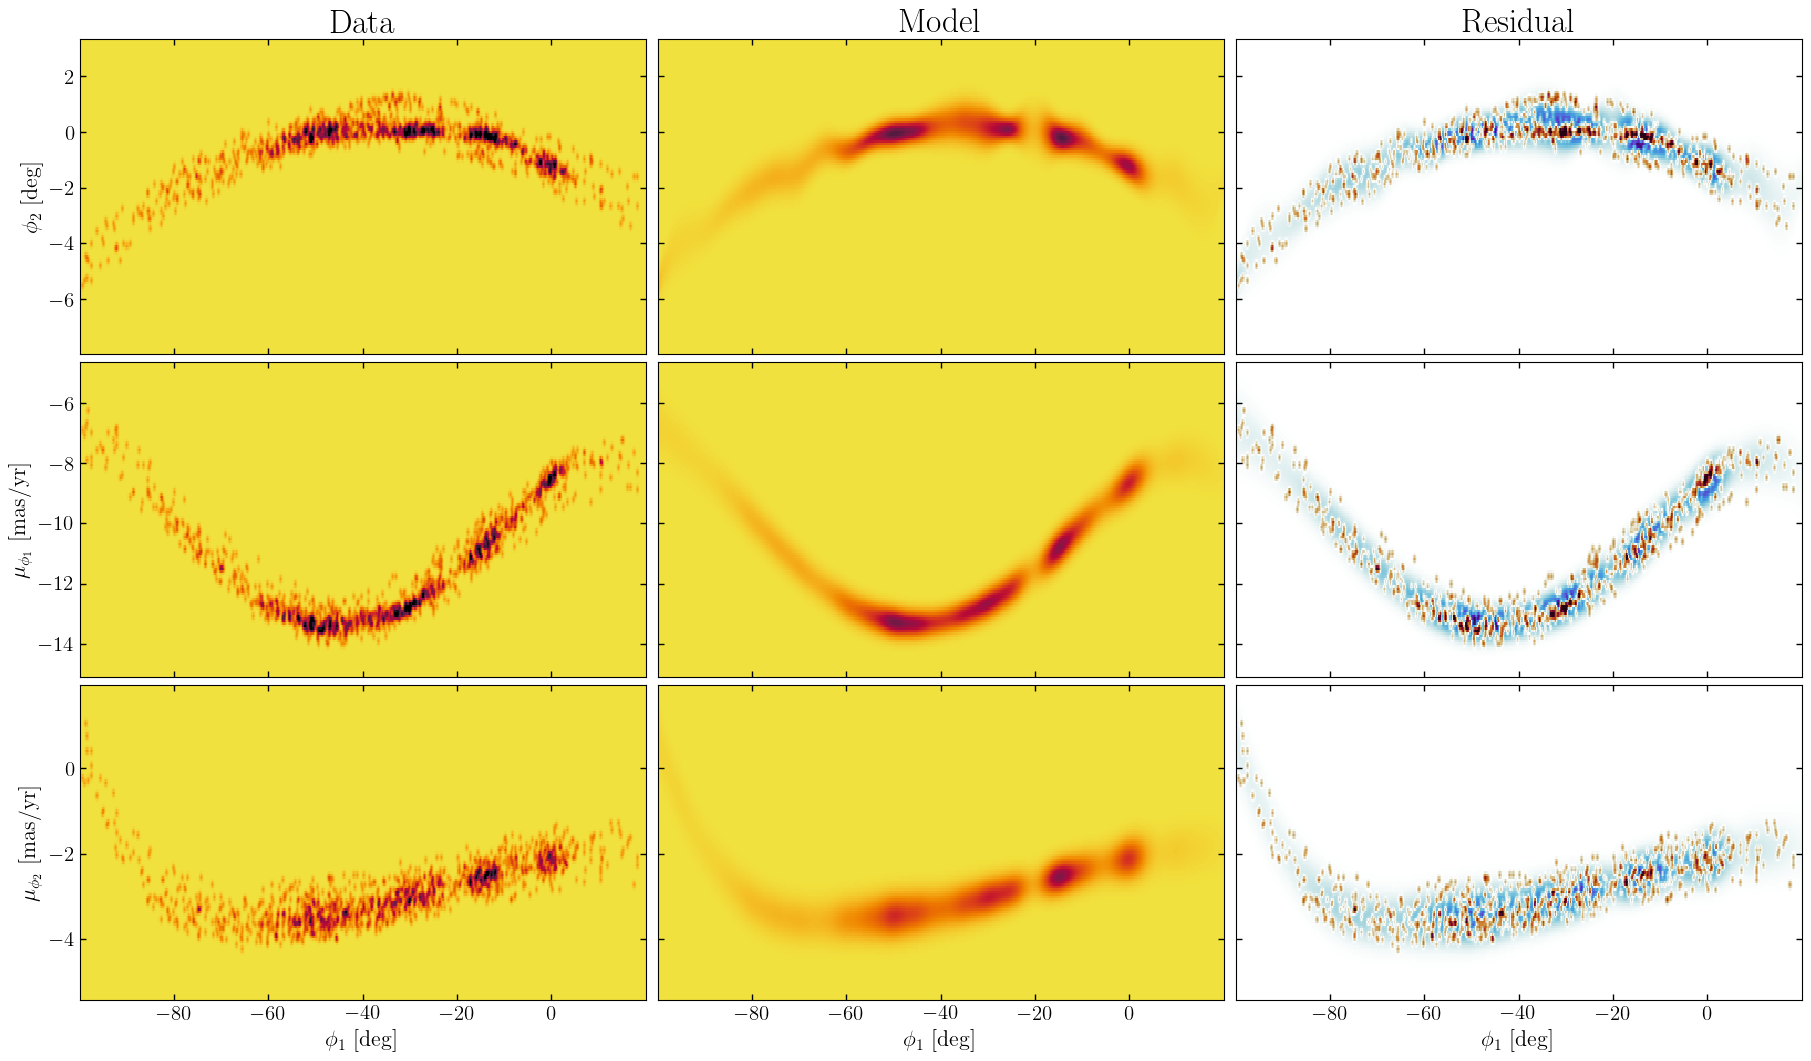

In [134]:
fig, axes = plt.subplots(
    len(stream_model.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(stream_model.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

plot_data_projections(
    data=stream_data,
    grids=plot_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap)
)
# plot_data_projections(
#     data=bkg_data,
#     grids=plot_grids,
#     axes=[axes[0, 0], axes[2,0]],
#     pcolormesh_kwargs=dict(rasterized=True, vmax=2.5, vmin=0, cmap=cmap),
#     coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
# )

stream_model.plot_model_projections(data=stream_data, grids=plot_grids, pars=stream_params, axes=axes[:, 1], label=False,
                                 pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap))
# bkg_model.plot_model_projections(data=bkg_data, grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
#                                  pars=bkg_params, axes=[axes[0, 1], axes[2,1]], label=False,
#                                  pcolormesh_kwargs=dict(rasterized=True, vmax=2.5, vmin=0, cmap=cmap))

stream_model.plot_residual_projections(
    grids=plot_grids, pars=stream_params,
    data=stream_data, axes=axes[:, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-0.5, vmax=0.5, cmap=cmr.fusion, rasterized=True)
)

axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.savefig('../../paper_figures/stream_model.pdf')
plt.show()

## Random check on the side

In [204]:
new_plot_grids = {}
for key, val in plot_grids.items():
    new_plot_grids[key] = val[::2]

In [249]:
pm1_poly = [[-74, -13.5], [-78, -15], [-92, -10], [-88, -9]]
pm1_patch = mpl.patches.Polygon(pm1_poly, edgecolor="k", facecolor="none")

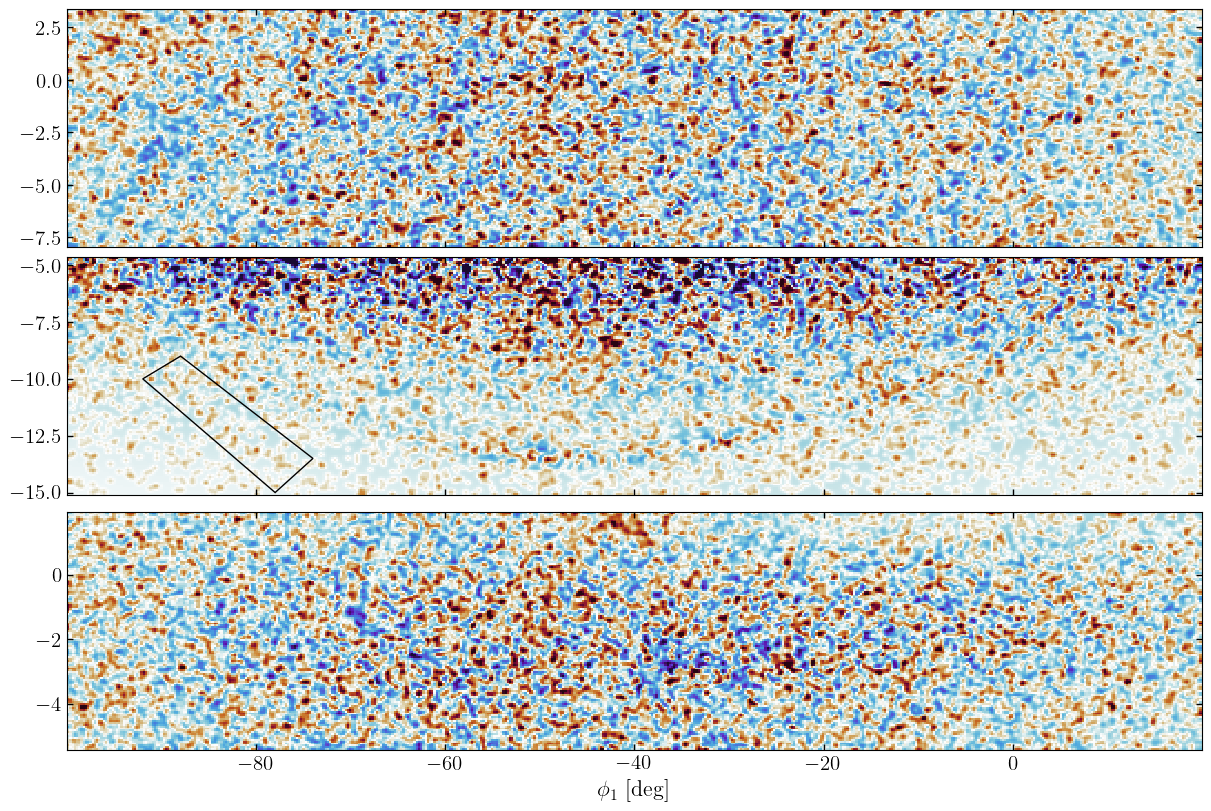

In [250]:
fig, axs = plt.subplots(3,1, figsize=(12,8), sharex=True, constrained_layout=True)
mm.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_expanded,
    data=run_data, axes=axs, label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion)
)
axs[1].add_patch(pm1_patch)
plt.show()

In [251]:
pm1_poly = [[-74, -13.5], [-78, -15], [-92, -10], [-88, -9]]
pm1_patch = mpl.patches.Polygon(pm1_poly, edgecolor="k", facecolor="none")

In [252]:
sel = pm1_patch.contains_points(jnp.array([run_data_['phi1'], run_data_['pm1']]).T)

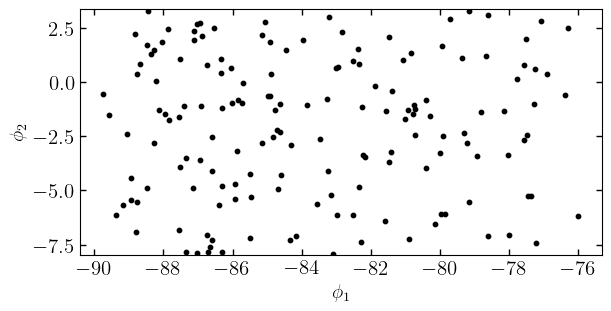

In [253]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(run_data_[sel]['phi1'], run_data_[sel]['phi2'], s=10)
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_ylim(coord_bounds['phi2'])
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
plt.show()

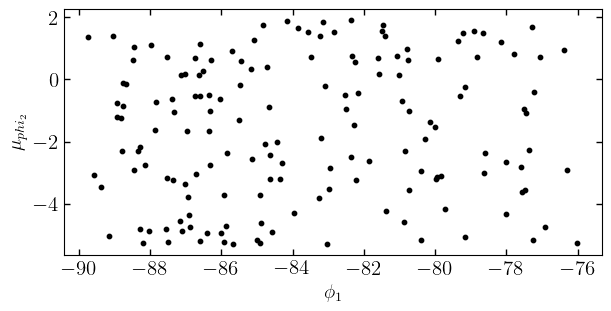

In [254]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(run_data_[sel]['phi1'], run_data_[sel]['pm2'], s=10)
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\mu_{phi_2}$')
plt.show()